In [9]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc as pm
import scipy.stats as stats
import helpsk as hlp

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [7]:
d = pd.read_csv("data/Howell1.csv", sep=";", header=0)
print(len(d))
d.head()

544


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [11]:
hlp.pandas.numeric_summary(d)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
height,544,0,0.0%,0,0.0%,138.3,27.6,0.2,-1.3,0.6,54.0,91.4,125.1,148.6,157.5,162.6,179.1
weight,544,0,0.0%,0,0.0%,35.6,14.7,0.4,-0.5,-0.9,4.2,12.5,22.0,40.1,47.2,51.6,63.0
age,544,0,0.0%,11,2.0%,29.3,20.8,0.7,0.5,-0.5,0.0,3.0,12.0,27.0,43.0,58.0,88.0
male,544,0,0.0%,287,53.0%,0.5,0.5,1.1,0.1,-2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


---

with pm.Model() as m4_3b:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + np.exp(b) * (d2.weight.values - xbar)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    trace_4_3b = pm.sample(1000, tune=1000)

In [13]:
d2 = d[d.age >= 18]
xbar = d2.weight.mean()

In [82]:
with pm.Model() as m4_3b:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    # mu = a + np.exp(b) * (d2.weight.values - xbar)
    # mu = a + np.exp(b) * (np.zeros(len(d2)) - d2.weight.mean())
    mu = a + np.exp(b) * (d2.weight.values - d2.weight.mean())
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    # trace_4_3b = pm.sample(1000, tune=1000)
    prior_samples = pm.sample_prior_predictive(samples=100, random_seed=RANDOM_SEED)


Sampling: [a, b, height, sigma]


In [83]:
prior_samples

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

(array([7.000e+00, 6.000e+00, 1.700e+01, 3.900e+01, 9.300e+01, 2.110e+02,
        3.980e+02, 7.840e+02, 1.494e+03, 2.571e+03, 4.321e+03, 5.639e+03,
        6.403e+03, 5.319e+03, 3.652e+03, 2.072e+03, 1.047e+03, 5.390e+02,
        2.810e+02, 1.480e+02, 9.000e+01, 3.100e+01, 1.900e+01, 7.000e+00,
        7.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([-20.95243749,  -4.75157862,  11.44928025,  27.65013912,
         43.85099799,  60.05185686,  76.25271573,  92.4535746 ,
        108.65443347, 124.85529235, 141.05615122, 157.25701009,
        173.45786896, 189.65872783, 205.8595867 , 222.06044557,
        238.26130444, 254.46216331, 270.66302218, 286.86388105,
        303.06473992, 319.26559879, 335.46645766, 351.66731653,
        367.8681754 , 384.06903427, 400.26989314, 416.47075201,
        432.67161088, 448.87246976, 465.07332863]),
 <BarContainer object of 30 artists>)

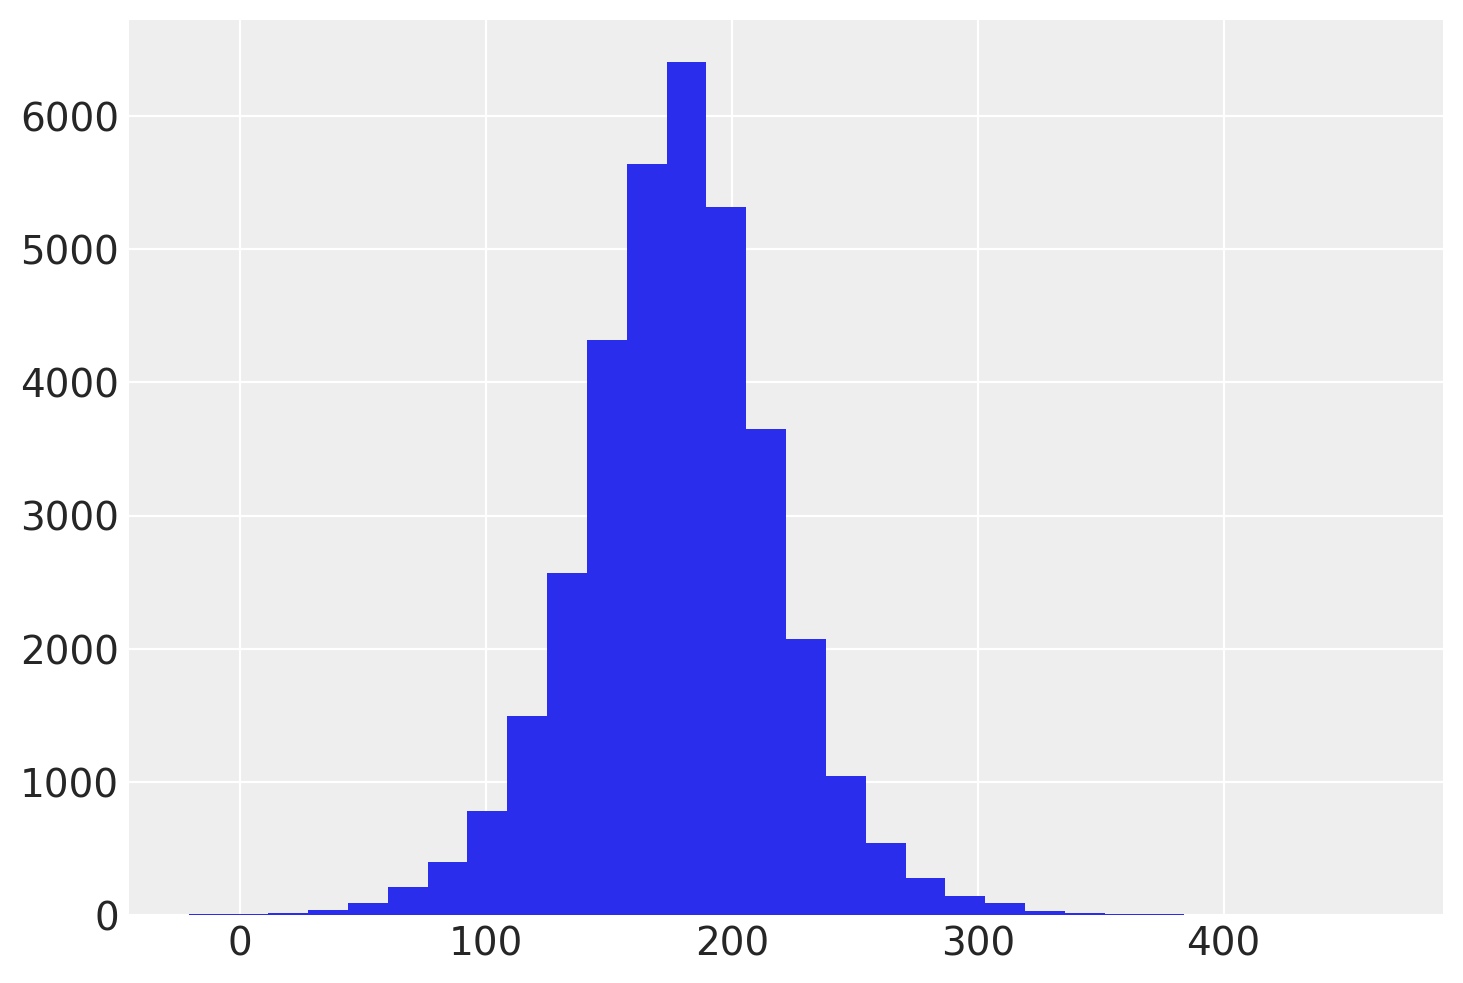

In [84]:
plt.hist(prior_samples.prior_predictive["height"].data[0].flatten(), bins=30)

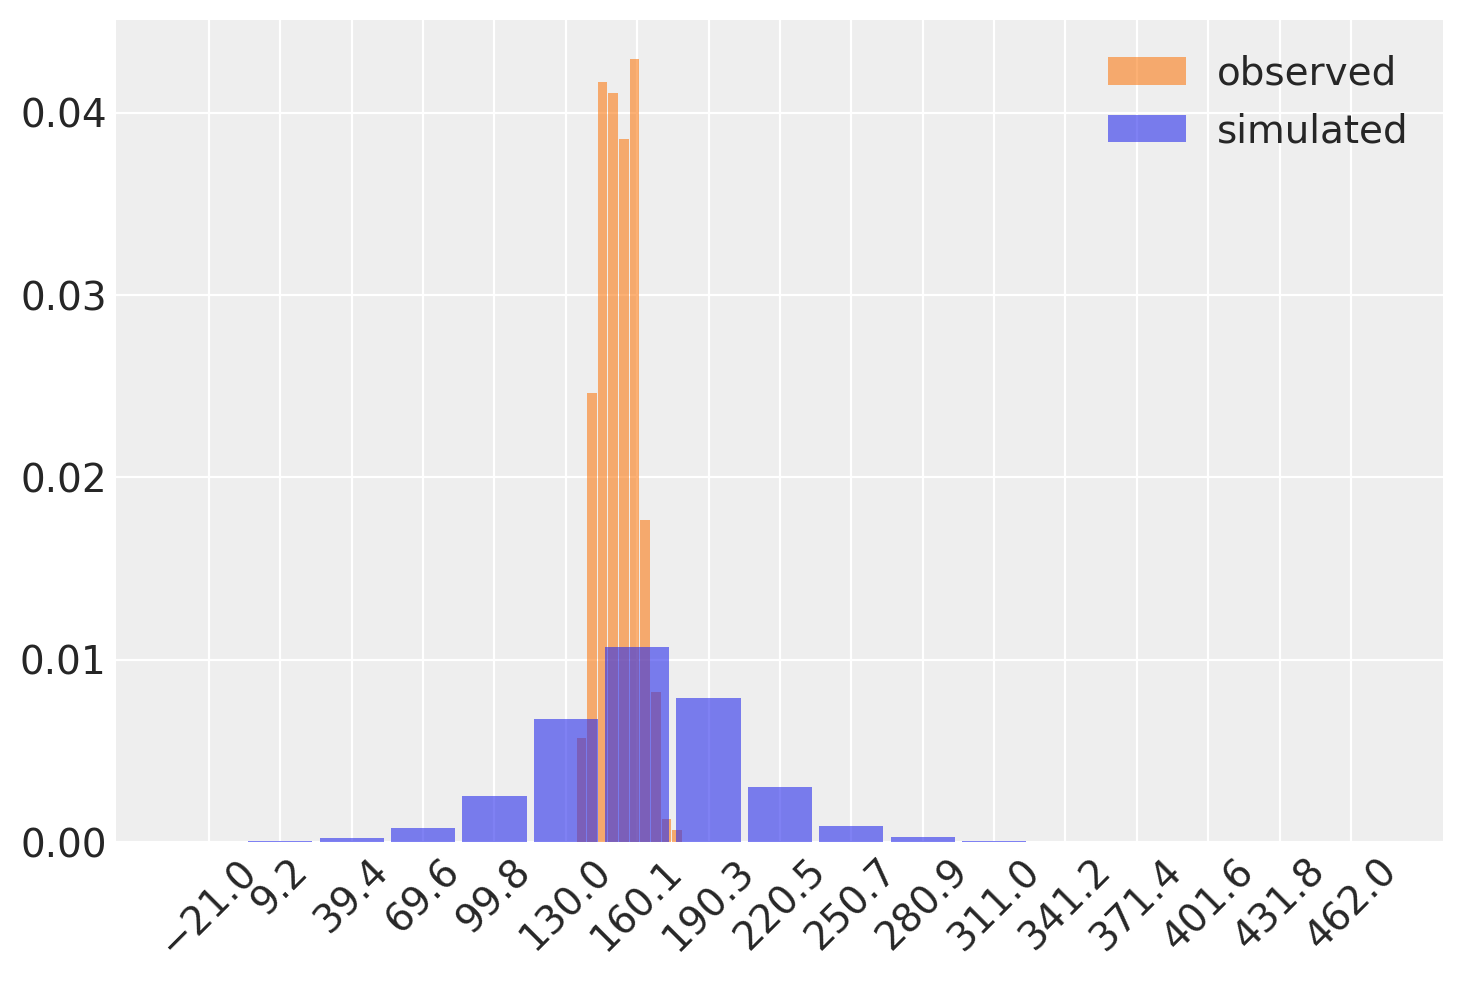

In [85]:
az.plot_dist(
    d2['height'],
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    prior_samples.prior_predictive["height"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated",
)
plt.xticks(rotation=45);

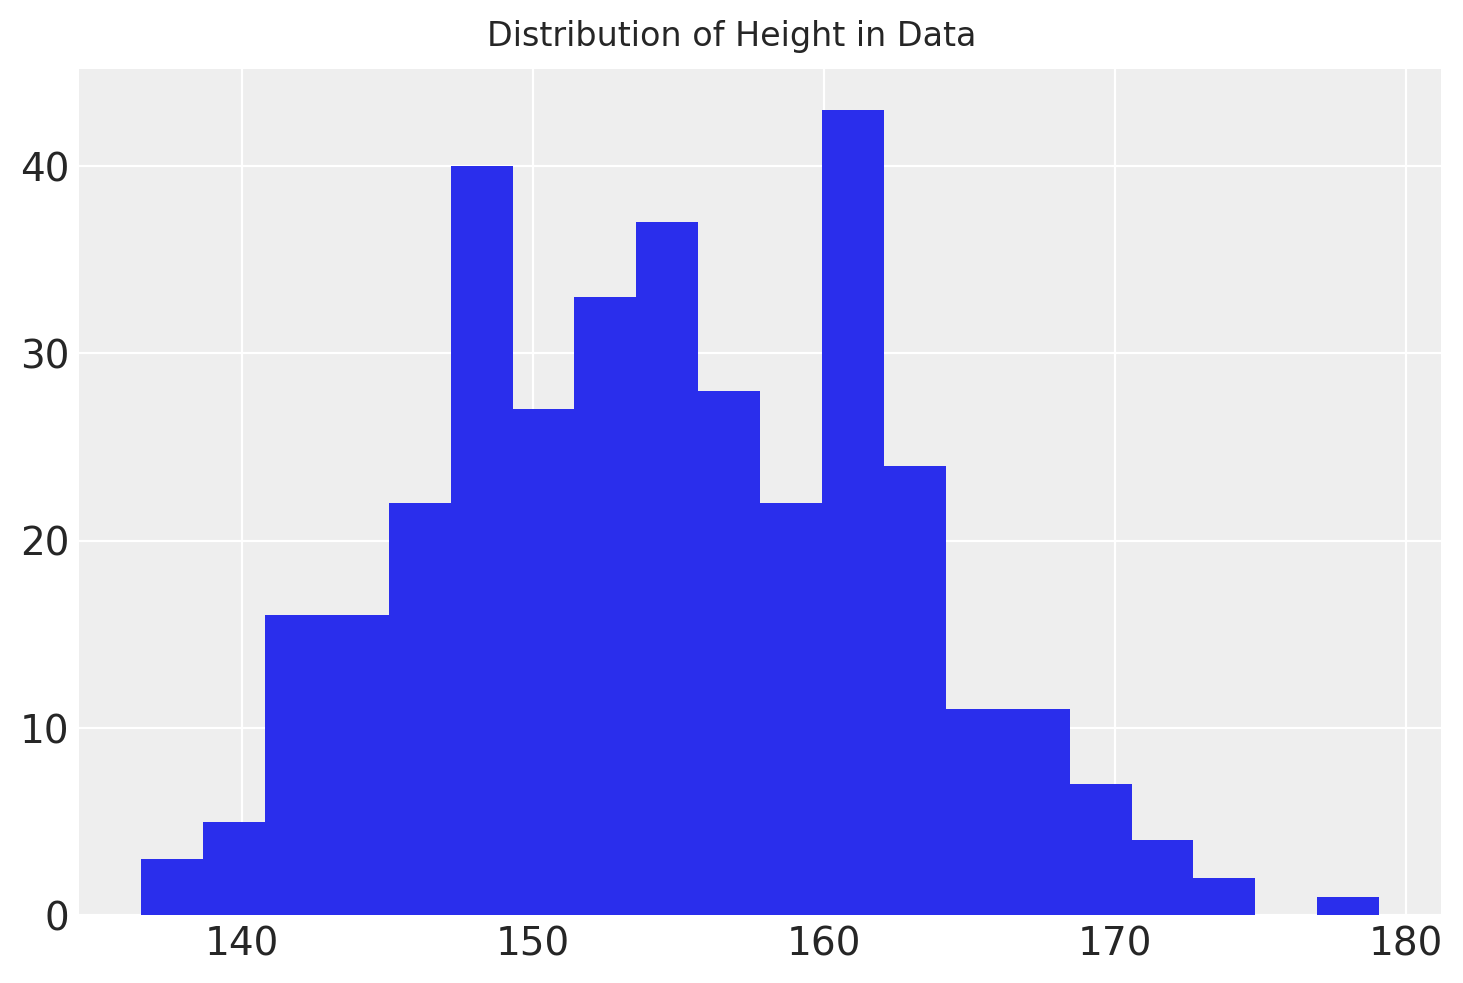

In [56]:
plt.hist(d2.height, bins=20)
plt.suptitle('Distribution of Height in Data');

In [52]:
# for each value of weight in data, give simulations of height based on prior distributions
prior_samples = prior_checks.prior_predictive['height'].data[0]
prior_samples.shape

(5000, 352)

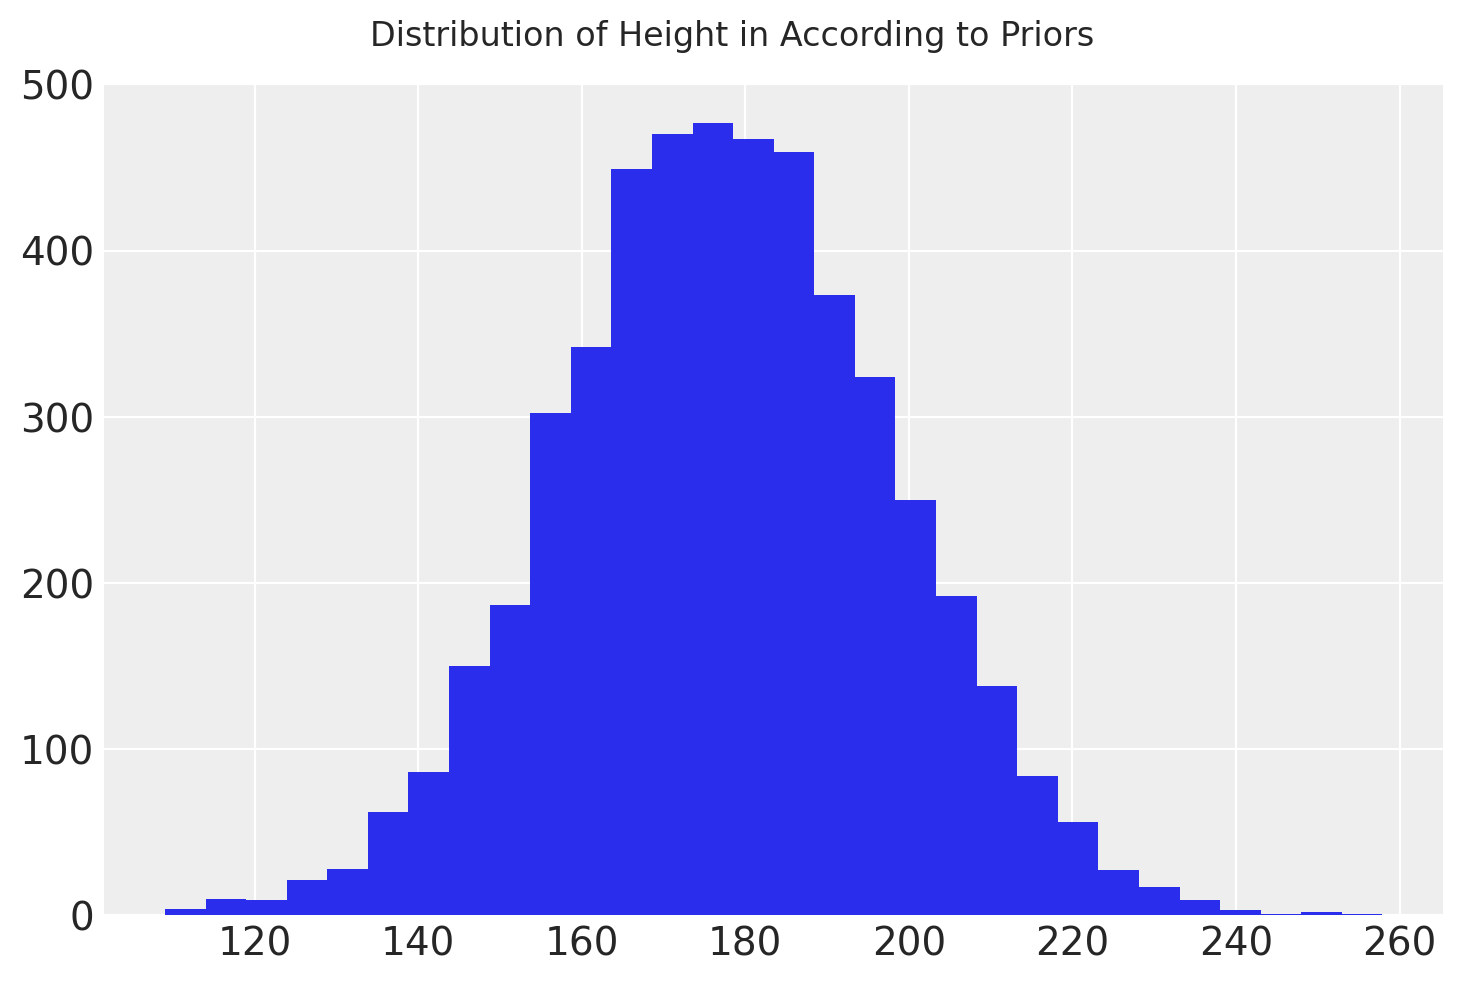

In [54]:
plt.hist(np.median(prior_samples, axis=1), bins=30)
plt.suptitle('Distribution of Height in According to Priors');

In [61]:
trace_4_3b

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [150]:
with m4_3b:
    idata_posterior = pm.sample(draws=1000, tune=1000)
    idata_predictive = pm.sample_posterior_predictive(
        idata_posterior,
        #var_names=["a", "b", "obs"],
        random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Sampling: [height]


In [151]:
idata_posterior

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [152]:
def get_dataset_names(inference_data: az.InferenceData) -> list[str]:
    return inference_data._group_names(None, None)

get_dataset_names(idata_posterior)

['posterior', 'sample_stats', 'observed_data']

In [153]:
def get_variable_names(inference_data: az.InferenceData) -> list[str]:
    return list(inference_data[get_dataset_names(inference_data)[0]].data_vars)

get_variable_names(idata_posterior)

['a', 'b', 'sigma']

In [154]:
get_variable_names(idata_predictive)

['height']

In [159]:
idata_posterior.posterior['a'].stack(sample=["chain", "draw"]).data.shape

(4000,)

In [163]:
def get_posterior_samples(posterior_inference: az.InferenceData, variable_name: str):
    return posterior_inference.posterior[variable_name].stack(sample=["chain", "draw"]).data.shape

get_posterior_samples(idata_posterior, 'a')

(4000,)

In [169]:
idata_predictive.posterior_predictive

<xarray.Dataset>
Dimensions:       (chain: 4, draw: 1000, height_dim_2: 352)
Coordinates:
  * chain         (chain) int64 0 1 2 3
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * height_dim_2  (height_dim_2) int64 0 1 2 3 4 5 6 ... 346 347 348 349 350 351
Data variables:
    height        (chain, draw, height_dim_2) float64 150.1 149.9 ... 160.9
Attributes:
    created_at:                 2023-01-10T05:28:03.282700
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  5.0.1

In [170]:
get_variable_names(idata_predictive)[0]

['height']

In [175]:
def get_prediction_samples(prediction_inference: az.InferenceData):
    variable_name = get_variable_names(prediction_inference)[0]
    return prediction_inference.posterior_predictive[variable_name].stack(sample=["chain", "draw"]).data

get_prediction_samples(idata_predictive).shape

(352, 4000)

In [176]:
posterior_predictive.posterior_predictive['height'].data.shape

(4, 1000, 352)

In [106]:
posterior_predictive.posterior_predictive.sel(chain=[0, 1, 2])['height'].data.shape

(3, 1000, 352)

In [104]:
posterior_predictive.posterior_predictive.stack(sample=["chain", "draw"])['height'].data.shape

(352, 4000)

In [91]:
predictions = posterior_predictive.posterior_predictive.stack(sample=["chain", "draw"])
predictions

ValueError: conflicting dimensions for multi-index product variables 'chain' ('sample',), 'draw' ('sample',)

In [88]:
az.convert_to_dataset(posterior_predictive.posterior_predictive['height'])

<xarray.Dataset>
Dimensions:       (chain: 4, draw: 1000, height_dim_2: 352)
Coordinates:
  * chain         (chain) int64 0 1 2 3
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * height_dim_2  (height_dim_2) int64 0 1 2 3 4 5 6 ... 346 347 348 349 350 351
Data variables:
    height        (chain, draw, height_dim_2) float64 149.5 150.1 ... 160.4

In [ ]:
idata.posterior.stack(draws=("chain", "draw"))

In [ ]:
with m4
ppc = pm.sample_posterior_predictive(
    trace_1, var_names=["a", "b", "obs"], random_seed=RANDOM_SEED
    )

In [60]:
az.summary(trace_4_3b, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a,154.604,0.270,154.096,155.119
b,-0.102,0.046,-0.194,-0.022
sigma,5.106,0.195,4.756,5.482
